In [1]:
import numpy as np
from numpy import pi
from torus_utils.contour import make_contour
from torus_utils.alg_functions import Xi_raw, Yps_raw, refine_Yps, Y, get_inidence_wave, sheet_number
from torus_utils.equations import (
    solve_abelian_ode,
    abelian_integral,
    refine,
    refine_5th,
)
from torus_utils.basic import get_branch_points
from torus_utils.k5_functions import MFunc, count_period_transactions

import matplotlib.pyplot as plt

## Parameters

In [2]:
K = 0.5 + 0.001j  # paramter K = kh

# lattice geometry
N_MIN = -80
N_MAX = 80

M_MIN = -80
M_MAX = 80

eta_11, eta_12, eta_21, eta_22 = get_branch_points(
    K
)  # branch points of Riemann surface

## Finding value of  $\Upsilon(1)$ on sheet 1

In [3]:
y0 = Xi_raw(1, K)
if abs(y0) > 1:
    y0 = 1 / y0

if K.imag == 0 and y0.imag < 0:
    y0 = np.conj(y0)

Yps0 = 2 * (y0 - 1 / y0)

## Defining contours $\sigma_{\alpha}$ and $\sigma_{\beta}$

In [4]:
points_beta, dx_b = (1, -1j, (-1 - 1j), (-1 + 1j), (1.1 + 1j), (1.1 + 0.1j), 1), 0.00001
points_alpha, dx_a = (1, (4 - 1j), -1j, (2 + 1j), (-1 + 1j), 1), 0.00001

cont_alpha = make_contour(points_alpha, dx_a)
cont_beta = make_contour(points_beta, dx_b)

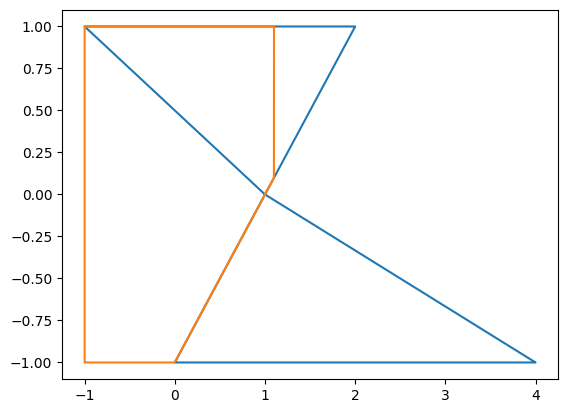

In [5]:
plt.figure()
plt.plot(cont_alpha.real, cont_alpha.imag)
plt.plot(cont_beta.real, cont_beta.imag)

plt.show()

## Find $T_{\beta}$ and points $b_i, c_i$

In [6]:
n_points = int(1e5)

T_beta = abelian_integral(cont_beta, K, Yps0)
_, b0, Yb0, _ = solve_abelian_ode(T_beta / 5, K, n_points)
_, b1, Yb1, _ = solve_abelian_ode(-T_beta / 5, K, n_points)
_, c0, Yc0, _ = solve_abelian_ode(2 * T_beta / 5, K, n_points)
_, c1, Yc1, _ = solve_abelian_ode(-2 * T_beta / 5, K, n_points)

b0_ref, c0_ref = refine(b0, c0, Yb0, Yc0, eta_21, K)

In [7]:
Yb0_ref = Yps_raw(b0_ref, K)
if abs(Yb0_ref + Yb0) < abs(Yb0_ref - Yb0):
    Yb0_ref = -Yb0_ref


Yc0_ref = Yps_raw(c0_ref, K)
if abs(Yc0_ref + Yc0) < abs(Yc0_ref - Yc0):
    Yc0_ref = -Yc0_ref


c0 = c0_ref[0]
b0 = b0_ref[0]

Yb0 = Yb0_ref[0]
Yc0 = Yc0_ref[0]

In [8]:
sigma_alpha = make_contour(
    (
        1,
        (eta_11 - 0.1 - 0.1j),
        (eta_11 + 0.1 - 0.1j),
        1,
        (eta_21 + 0.1 + 0.1j),
        (eta_21 - 0.1 + 0.1j),
        1,
    ),
    1e-5,
)
Y_on_sigma_alpha = Y(sigma_alpha, Yps0, K)

func = MFunc(K, eta_21, b0, Yb0, c0, Yc0)

G1_sigma_alpha = func.G1(sigma_alpha, Y_on_sigma_alpha)
G2_sigma_alpha = func.G2(sigma_alpha, Y_on_sigma_alpha)
G3_sigma_alpha = func.G3(sigma_alpha, Y_on_sigma_alpha)
G4_sigma_alpha = func.G4(sigma_alpha, Y_on_sigma_alpha)

print(count_period_transactions(G1_sigma_alpha))
print(count_period_transactions(G2_sigma_alpha))
print(count_period_transactions(G3_sigma_alpha))
print(count_period_transactions(G4_sigma_alpha))

-3.9999999999999827
-2.999999999999967
-1.99999999999999
-1.0000000000000062


## Construction of the integration contour

In [9]:
theta = np.linspace(0, 2 * pi, 10_000)
sdvig_na_pi = make_contour(
    (1, (eta_11 - 0.1 - 0.1j), (eta_11 + 0.1 - 0.1j), 1), 0.00001
)


integration_contour = np.exp(1j * theta)
integration_contour = integration_contour + 0.2j * np.sin(theta) ** 2
integration_contour = integration_contour - 0.05 * np.exp(-((theta - pi) ** 2) / 0.01)
integration_contour = integration_contour + 0.02 * np.exp(-((theta) ** 2) / 0.01)
integration_contour = integration_contour + 0.02 * np.exp(
    -((theta - 2 * pi) ** 2) / 0.01
)


Y_on_integration_contour = Y(integration_contour, Yps0, K)
Y_on_sdvig_na_pi = Y(sdvig_na_pi, Yps0, K)

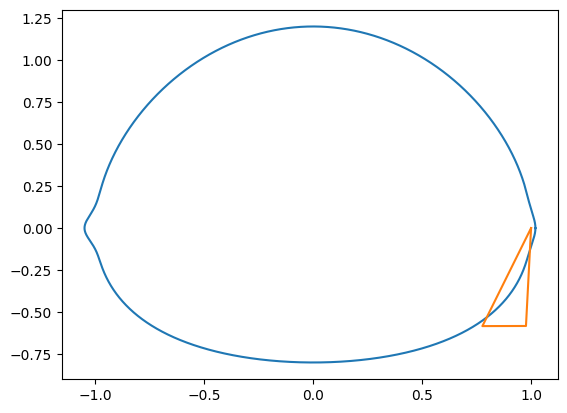

In [10]:
plt.figure()
plt.plot(integration_contour.real, integration_contour.imag)
plt.plot(sdvig_na_pi.real, sdvig_na_pi.imag)

plt.show()

## Build functions $F_1, ..., F_4$ on sheet 1 and sheet 2

In [11]:
F1 = np.zeros((4, 2, len(integration_contour)), dtype=np.complex_)

# Funictions F on sheet 1
F1[0, 0, :] = refine_5th(
    (func.G1(integration_contour, Y_on_integration_contour)) ** (1 / 5)
)
F1[1, 0, :] = refine_5th(
    (func.G2(integration_contour, Y_on_integration_contour)) ** (1 / 5)
)
F1[2, 0, :] = refine_5th(
    (func.G3(integration_contour, Y_on_integration_contour)) ** (1 / 5)
)
F1[3, 0, :] = refine_5th(
    (func.G4(integration_contour, Y_on_integration_contour)) ** (1 / 5)
)


# Funictions F on sheet 2
G = [func.G1, func.G2, func.G3, func.G4]
for n in range(len(G)):
    sdvig = refine_5th((G[n](sdvig_na_pi, Y_on_sdvig_na_pi)) ** (1 / 5))

    F1[n, 1, :] = (G[n](integration_contour, -Y_on_integration_contour)) ** (1 / 5)
    F1[n, 1, 0] = sdvig[-1]
    F1[n, 1, :] = refine_5th(F1[n, 1, :])
    F1[n, 1, 0] = F1[n, 1, -1]

In [12]:
from torus_utils.refines import refine_on_k5

F = np.zeros(
    (5, 2, len(integration_contour)), dtype=np.complex_
)  # functions F1, ..., F4 on integration_contour

F[0, 0, :] = 1
F[0, 1, :] = 1

# Funictions F on sheet 1
F[1, 0, :] = refine_on_k5(
    (func.G1(integration_contour, Y_on_integration_contour)) ** (1 / 5)
)

F[2, 0, :] = refine_on_k5(
    (func.G2(integration_contour, Y_on_integration_contour)) ** (1 / 5)
)

F[3, 0, :] = refine_on_k5(
    (func.G3(integration_contour, Y_on_integration_contour)) ** (1 / 5)
)

F[4, 0, :] = refine_on_k5(
    (func.G4(integration_contour, Y_on_integration_contour)) ** (1 / 5)
)


# Funictions F on sheet 2
G = [func.G1, func.G2, func.G3, func.G4]
for n in range(len(G)):
    sdvig = refine_on_k5((G[n](sdvig_na_pi, Y_on_sdvig_na_pi)) ** (1 / 5))

    F[n + 1, 1, :] = (G[n](integration_contour, -Y_on_integration_contour)) ** (1 / 5)
    F[n + 1, 1, 0] = sdvig[-1]
    F[n + 1, 1, :] = refine_on_k5(F[n + 1, 1, :])
    F[n + 1, 1, 0] = F[n + 1, 1, -1]

## Define incident waves

In [13]:
PSI = np.deg2rad(210)

In [14]:
from typing import NamedTuple

x_in, y_in = get_inidence_wave(PSI, K)


class IncidentWave(NamedTuple):
    x_in: complex
    y_in: complex
    sheet_number: int
    sign: int


incident_waves = [
    IncidentWave(x_in, y_in, sheet_number(pi + PSI), -1),
    IncidentWave(y_in / x_in, 1 / x_in, sheet_number(13*pi/3 + PSI), -1),
    IncidentWave(1 / y_in, x_in / y_in, sheet_number(23*pi/3 + PSI), -1),
    IncidentWave(y_in / x_in, y_in, sheet_number(5*pi/3 - PSI), 1),
    IncidentWave(x_in, x_in / y_in, sheet_number(5*pi - PSI), 1),
    IncidentWave(1 / y_in, 1 / x_in, sheet_number(25/3*pi - PSI), 1),
]

## Finding coefficients $s$ and $q$

In [15]:
xi = np.exp(2j * pi / 5)

s0 = np.zeros((6, 2), dtype=np.complex_)
s = np.zeros((6, 4, 2), dtype=np.complex_)

d0 = [b0, c0, c0, b0]  # this is the set of parameter in the equation
Yd0 = [Yb0, Yc0, -Yc0, -Yb0]

for n_pt, inc_wave in enumerate(incident_waves):
    _x_in = inc_wave.x_in.copy()
    _y_in = inc_wave.y_in.copy()
    n_sheet = inc_wave.sheet_number
    sig = inc_wave.sign

    Y_in = (_x_in + 1) * (
        _y_in - _x_in / _y_in
    )  # % assign Ypsilon to the incidence point

    n_sheet_K2 = n_sheet % 2
    if n_sheet_K2 == 0:
        n_sheet_K2 = 2

    nomer_pachki = int(
        np.floor((n_sheet - n_sheet_K2) / 2) % 5
    )  # % nomer pachki listov v K5. Takes values 0,1,2,3,4

    # Finding values of interesting functions
    def_cont = np.linspace(1, _x_in, 1000)
    Y_def_cont = Yps_raw(def_cont, K)
    Y_def_cont[0] = Yps0
    Y_def_cont = refine_Yps(Y_def_cont)

    # raw shots from 1 to x_in by G (raw means without correction)
    raw_shot = np.zeros((4, 2, len(def_cont)), dtype=np.complex_)
    F_value = np.zeros(
        (4, 2), dtype=np.complex_
    )  # they are values of F_j (j = 1..4) at the points over $x_in$ for sheets 1 and 2

    for i in range(len(G)):
        raw_shot[i, 0, :] = (G[i](def_cont, Y_def_cont)) ** (1 / 5)
        raw_shot[i, 1, :] = (G[i](def_cont, -Y_def_cont)) ** (1 / 5)

    # correcting the paths and taking the values at the ends
    for m in range(4):
        for n in range(2):
            raw_shot[m, n, 0] = F[m + 1, n, 0]
            raw_shot[m, n, :] = refine_on_k5(raw_shot[m, n, :])

            F_value[m, n] = raw_shot[m, n, -1]

    # start making s
    s0[n_pt, 0] = sig / (20j * pi) * Y_in
    s0[n_pt, 1] = sig / (20j * pi)

    for m in range(4):
        F_m = F_value[m, n_sheet_K2 - 1] * xi ** ((m + 1) * nomer_pachki)

        s[n_pt, m, 0] = sig / (20j * pi) * Y_in / (_x_in - eta_21) / F_m
        s[n_pt, m, 1] = sig / (20j * pi) / (d0[m] - eta_21) / F_m

In [16]:
# making integrands
q_p = np.zeros((5, len(integration_contour)), dtype=np.complex_)
q_pp = np.zeros((5, len(integration_contour)), dtype=np.complex_)

# % aliases
x = integration_contour
Yy = Y_on_integration_contour

for n_pt, inc_wave in enumerate(incident_waves):
    x_s = inc_wave.x_in
    y_s = inc_wave.y_in

    q_p[0, :] += s0[n_pt, 0] / (x - x_s)
    q_pp[0, :] += s0[n_pt, 1] / (x - x_s)

    for t in range(1, 5):
        q_p[t, :] += (x - eta_21) * (
            s[n_pt, t - 1, 0] / (x - x_s)
            - s[n_pt, t - 1, 1] * Yd0[t - 1] / (x - d0[t - 1])
        )

        # q_pp{t} = q_pp{t} + ...
        #         (d0(t) - eta_21) .* ( s{n_pt}(t,2) ./ (x - x_s)  - s{n_pt}(t,2) ./ (x - d0(t)) ) ;

        q_pp[t, :] += (d0[t - 1] - eta_21) * (
            (s[n_pt, t - 1, 1]) / (x - x_s) - s[n_pt, t - 1, 1] / (x - d0[t - 1])
        )

In [17]:
def build_field(
    geometry: list[int, int, int, int],
    A: list[np.ndarray, np.ndarray],
    inc_waves: list[tuple[complex, complex, int]],
    x,
    y,
    dx,
    Y_cont,
):
    m_min, m_max, n_min, n_max = geometry

    const_integrand_1 = A[0] * dx / Y_cont
    const_integrand_2 = A[1] * dx / Y_cont

    result = np.zeros((m_max - m_min + 1, n_max - n_min + 1), dtype=np.complex_)

    m_idx = 0
    for m in range(m_min, m_max + 1):
        n_idx = 0
        for n in range(n_min, n_max + 1):
            # the incident field
            for x_s, y_s, sign in inc_waves:
                result[m_idx, n_idx] += sign * (x_s) ** m * (y_s) ** n


            # w - factor
            w_factor = x**m * y**n

            # adding Lambda_3
            result[m_idx, n_idx] += np.sum(w_factor * const_integrand_1)

            # adding Lambda_4
            result[m_idx, n_idx] -= np.sum(w_factor * const_integrand_2)
            n_idx = n_idx + 1
        m_idx = m_idx + 1
    return result


In [18]:
xi_vec = np.array([xi**n for n in range(5)])

Y_int_cont = -Yy.copy()

A_integrand_Lambda_3 = (np.sum((q_p + q_pp * Y_int_cont) * F[:, 1, :], axis=0))[:-1]
A_integrand_Lambda_4 = (xi_vec @ ((q_p + q_pp * Y_int_cont) * F[:, 1, :]))[:-1]

dx_1 = integration_contour[1:] - integration_contour[:-1]
dx_2 = 0 * dx_1
dx_2[1:] = dx_1[:-1]
dx_2[0] = dx_1[-1]

dx_int_cont = 1 / 2 * (dx_1 + dx_2)
y_int_cont = -(3 / 2 * K**2 - 6 + x + 1 / x) / (2 * (1 + 1 / x)) - Yy / (2 * (x + 1))
y_int_cont = y_int_cont[:-1]
x_int_cont = x[:-1]
Y_int_cont = -Yy[:-1]

bottom_geometry = [M_MIN, M_MAX, N_MIN, 0]
A_bottom = [A_integrand_Lambda_3, A_integrand_Lambda_4]

if PSI >= 5*pi/3 and PSI < 2 *pi:
    inc_wave_bottom = [(x_in, y_in, 1), (x_in, x_in / y_in, -1)]
    
else:
    print("Ne He")
    inc_wave_bottom = [(x_in, y_in, 1)]

result_bottom = build_field(
    bottom_geometry,
    A_bottom,
    inc_wave_bottom,
    x_int_cont,
    y_int_cont,
    dx_int_cont,
    Y_int_cont,
)

Y_int_cont = Yy.copy()

A_integrand_Lambda_1 = (np.sum((q_p + q_pp * Y_int_cont) * F[:, 0, :], axis=0))[:-1]
A_integrand_Lambda_2 = (xi_vec @ ((q_p + q_pp * Y_int_cont) * F[:, 0, :]))[:-1]

y_int_cont = -(3 / 2 * K**2 - 6 + x + 1 / x) / (2 * (1 + 1 / x)) + Yy / (2 * (x + 1))
y_int_cont = y_int_cont[:-1]
Y_int_cont = Yy[:-1]

top_geometry = [M_MIN, 0, 0, N_MAX]
A_top = [A_integrand_Lambda_2, A_integrand_Lambda_1]

if PSI > pi and PSI < 5*pi/3:
    inc_wave_top = [(x_in, y_in, 1),]
elif PSI > 2*pi/3 and PSI < pi:
    inc_wave_top = [(x_in, y_in, 1), (y_in/x_in, y_in, -1)]
elif PSI > pi/3 and PSI <= 2*pi/3:
    inc_wave_top = [(x_in, y_in, 1), (y_in/x_in, y_in, -1)]
elif PSI >= 5*pi/3 and PSI < 2*pi:
    inc_wave_top = []

result_top = build_field(
    top_geometry,
    A_top,
    inc_wave_top,
    x_int_cont,
    y_int_cont,
    dx_int_cont,
    Y_int_cont,
)

Ne He


## Plot the result

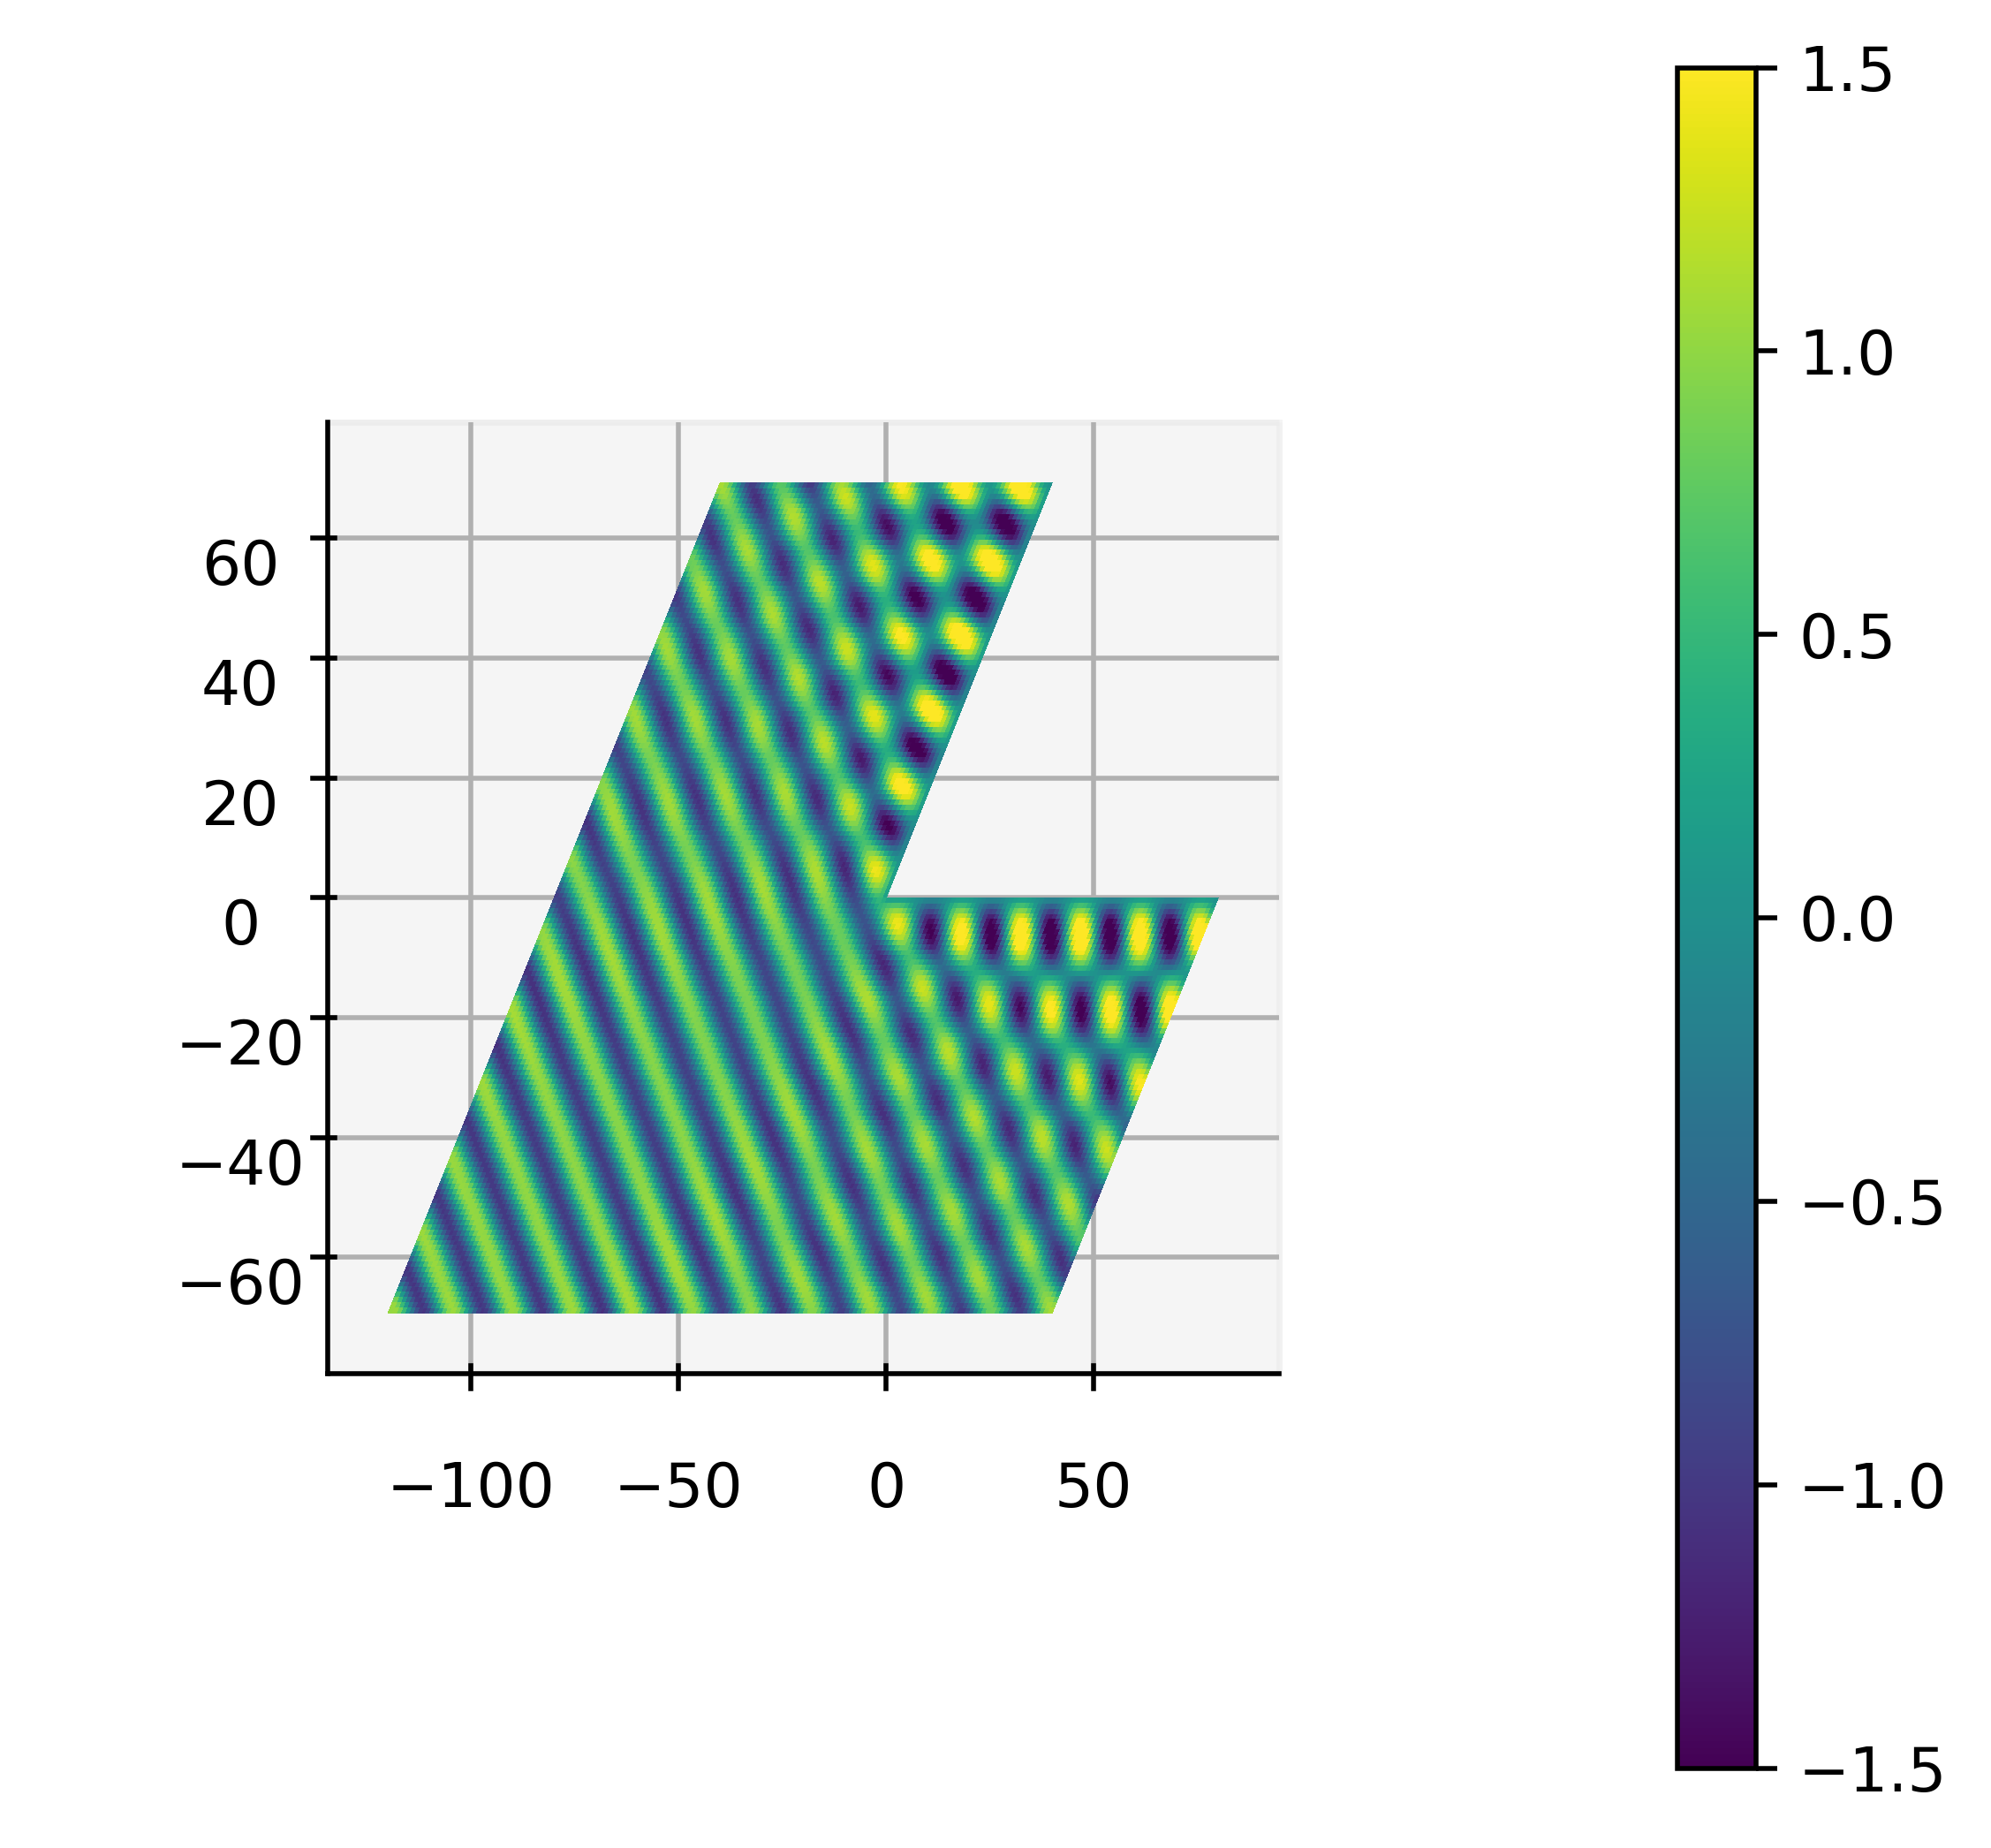

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib import cm
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1 import make_axes_locatable
plt.rcParams['figure.dpi'] = 500

gs = GridSpec(1, 2, width_ratios = [0.95, 0.05])
fig = plt.figure(figsize = (5, 5))
ax = fig.add_subplot(gs[0], projection = '3d', proj_type = 'ortho')
cbar_ax = fig.add_subplot(gs[1])

Y_bottom = np.arange(-80, 1, 1)
X_bottom = np.arange(-80, 81, 1)
X_bottom, Y_bottom = np.meshgrid(X_bottom, Y_bottom)

Y_top = np.arange(0, 81, 1)
X_top = np.arange(-80, 1, 1)
X_top, Y_top = np.meshgrid(X_top, Y_top)

X_tr_top = (X_top + Y_top * 1 / 2)
Y_tr_top = Y_top * np.sin(pi / 3)

X_tr_bottom = (X_bottom + Y_bottom * 1 / 2)
Y_tr_bottom = Y_bottom * np.sin(pi / 3)

Z_bottom = result_bottom.real
Z_top = result_top.real

surf = ax.plot_surface(X_tr_bottom, Y_tr_bottom, Z_bottom.real.T, cmap = cm.viridis,
                           linewidth = 0, antialiased = False, rstride=1, cstride=1, vmin=-1.5, vmax=1.5)

surf = ax.plot_surface(X_tr_top, Y_tr_top, Z_top.real.T, cmap = cm.viridis,
                           linewidth = 0, antialiased = False, rstride=1, cstride=1, vmin=-1.5, vmax=1.5)

ax.view_init(elev=90, azim=-90)
# ax.w_zaxis.line.set_lw(0.)
ax.set_zticks([])
plt.colorbar(surf, cax = cbar_ax)

plt.show()